In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Create test model


In [11]:
# Points
d = {'X': [1, 0, 1, 2, 0, 1, 2, 1], 'Y': [0, 1, 1, 1, 2, 2, 2, 3], 'Name': ['A','B','C','D','E','F','G','H']}

pf = pd.DataFrame(data=d)
pf

,X,Y,Name
0,1,0,A
1,0,1,B
2,1,1,C
3,2,1,D
4,0,2,E
5,1,2,F
6,2,2,G
7,1,3,H


Text(0.5, 1.0, 'points')

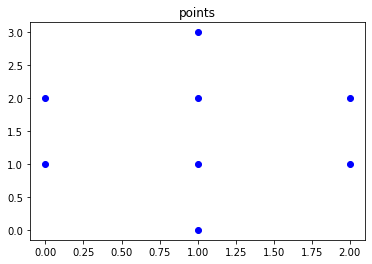

In [12]:
plt.plot(pf.X,pf.Y,'bo')
plt.title('points')

In [14]:
pf.iloc[0,:2]

X    1
Y    0
Name: 0, dtype: object

In [38]:
d = {'Xb': [1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 2], 
     'Yb': [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], 
     'Xe': [0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1], 
     'Ye': [1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3],
     'Name': ['AB','AC','AD','BC','BE','CD','CF','DG','EF','EH','FG','FH','GH']}
df = pd.DataFrame(data=d)
df

,Xb,Yb,Xe,Ye,Name
0,1,0,0,1,AB
1,1,0,1,1,AC
2,1,0,2,1,AD
3,0,1,1,1,BC
4,0,1,0,2,BE
5,1,1,2,1,CD
6,1,1,1,2,CF
7,2,1,2,2,DG
8,0,2,1,2,EF
9,0,2,1,3,EH


Instead of having a bloated table, I will define here a few functions that could simply create the extra geometric properties of the network on demand.

In [52]:
#Support geometry functions
def section_len(df):
    return np.sqrt((df.Xe-df.Xb)**2+(df.Ye-df.Yb)**2)

def section_angle(df):
    return np.arctan((df.Ye-df.Yb)/(df.Xe-df.Xb))

In [53]:
section_angle(df)

0    -0.785398
1     1.570796
2     0.785398
3     0.000000
4     1.570796
5     0.000000
6     1.570796
7     1.570796
8     0.000000
9     0.785398
10    0.000000
11    1.570796
12   -0.785398
dtype: float64

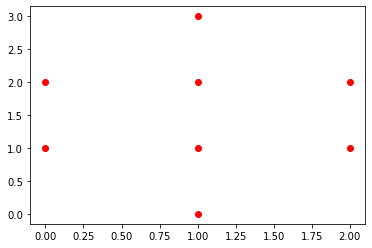

In [29]:
plt.plot(pf.X,pf.Y, 'ro')

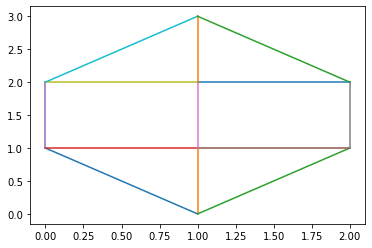

In [96]:
plt.plot([df.Xb,df.Xe],[df.Yb,df.Ye])

Create shorter segments

In [109]:
dx = 0.1
L = section_len(df)
alpha = section_angle(df)
X_len = df.Xe-df.Xb 
Y_len = df.Ye-df.Yb

DFN_Mat2 = np.array([[],[],[],[],[]]).T
for i in range(0,len(df)):
    n_seg = np.floor(L[i]/dx)
    d_seg = L/n_seg

    for j in range(0,int(n_seg)):
        newline0 = df.Xb[i] + j*X_len[i]/n_seg
        newline1 = df.Yb[i] + j*Y_len[i]/n_seg
        newline2 = df.Xb[i] + (j+1)*X_len[i]/n_seg
        newline3 = df.Yb[i] + (j+1)*Y_len[i]/n_seg
        newline4 = df.Name[i]
        
        DFN_Mat2 = np.vstack([DFN_Mat2,[newline0,newline1,newline2,newline3,newline4]])
        

sf = pd.DataFrame(DFN_Mat2, columns = ['Xb','Yb','Xe','Ye','Name'])
sf.iloc[:,0:4] = sf.iloc[:,0:4].astype('float')

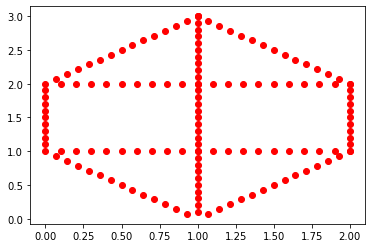

In [110]:
plt.plot(sf.Xe,sf.Ye,'ro')

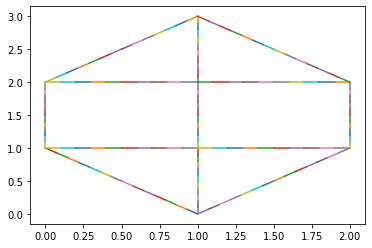

In [111]:
plt.plot([sf.Xb,sf.Xe],[sf.Yb,sf.Ye])

We have to test different discretizations

## Connectivity matrix

In [113]:
eps = 0.001
Connect_Mat = np.ones([len(sf),6])*(-999) 


for i in range(0,len(sf)):
        D55 = abs(sf.Xb[:]-sf.Xb[i])
        D66 = abs(sf.Yb[:]-sf.Yb[i])
        D77 = abs(sf.Xe[:]-sf.Xe[i])
        D88 = abs(sf.Ye[:]-sf.Ye[i])
        D57 = abs(sf.Xe[:]-sf.Xb[i])
        D68 = abs(sf.Ye[:]-sf.Yb[i])
        D75 = abs(sf.Xb[:]-sf.Xe[i])
        D86 = abs(sf.Yb[:]-sf.Ye[i])
        
        index = np.where(((D55<=eps) & (D66<=eps)) | ((D77<=eps) & (D88<=eps)) | ((D57<= eps) & (D68<=eps)) | ((D75<=eps) & (D86<=eps)))
        k = 0
        for j in range(0,min(5,len(index[0]))):
            if (index[0][j]!=i):
                Connect_Mat[i,k] = index[0][j]
                k = k+1

In [114]:
Connect_Mat

array([[   1.,   14.,   24., -999., -999., -999.],
       [   0.,    2., -999., -999., -999., -999.],
       [   1.,    3., -999., -999., -999., -999.],
       [   2.,    4., -999., -999., -999., -999.],
       [   3.,    5., -999., -999., -999., -999.],
       [   4.,    6., -999., -999., -999., -999.],
       [   5.,    7., -999., -999., -999., -999.],
       [   6.,    8., -999., -999., -999., -999.],
       [   7.,    9., -999., -999., -999., -999.],
       [   8.,   10., -999., -999., -999., -999.],
       [   9.,   11., -999., -999., -999., -999.],
       [  10.,   12., -999., -999., -999., -999.],
       [  11.,   13., -999., -999., -999., -999.],
       [  12.,   38.,   48., -999., -999., -999.],
       [   0.,   15.,   24., -999., -999., -999.],
       [  14.,   16., -999., -999., -999., -999.],
       [  15.,   17., -999., -999., -999., -999.],
       [  16.,   18., -999., -999., -999., -999.],
       [  17.,   19., -999., -999., -999., -999.],
       [  18.,   20., -999., -9